# 下面是手写版教程，完整版直接拉到最后

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
filename_list = glob.glob("./data/*.jpg")

In [3]:
resize_mul = 5
img_list = []
img_gray_list = []
img_gray_float_list = []
for filename in filename_list:
    img = cv2.imread(filename)
    x, y, _ = img.shape
    img = cv2.resize(img, (y // resize_mul, x // resize_mul))
    img_list.append(img)
    
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_gray_list.append(img_gray)
    
    img_gray_float = np.float32(img_gray)
    img_gray_float_list.append(img_gray_float)

In [4]:
def show_img(img):
    img = np.uint8(img)
    if(len(img.shape)==3):
        x, y, _ = img.shape
    else:
        x,y = img.shape
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
# img = img_list[0].copy()
# gray = img_gray_float_list[0].copy()
# dst = cv2.cornerHarris(gray, 2, 3, 0.04)
# dst = cv2.dilate(dst,None)

# topk = 1500
# threshold = 0.05
# topk_num = -np.sort(-dst.reshape(1,-1))[0,topk]

# img[dst>dst.max() * threshold] = [0,0,255]
# # img[dst>topk_num] = [0,0,255]
# show_img(img)

In [6]:
from skimage.feature import corner_peaks
from scipy.spatial.distance import cdist

In [7]:
def simple_descriptor(patch):
    ave = np.mean(patch)
    std = np.std(patch)
    if std==0:
        std=1
    result_patch = (patch - ave) / std
    return result_patch.flatten()

In [8]:
def keypoint_description(image,keypoint,desc_func,patch_size=16):
    keypoint_desc = []
    for i,point in enumerate(keypoint):
        x,y = point
        patch = image[x-patch_size//2:x+int(np.ceil(patch_size/2)),y-patch_size//2:y+int(np.ceil(patch_size/2))]
        description = desc_func(patch)
        keypoint_desc.append(description)
    return np.array(keypoint_desc)

def description_matches(desc1,desc2,threshold=0.5):
    distance_array = cdist(desc1, desc2)
    matches = []
    i=0
    for each_distance_list in distance_array:
        arg_list = np.argsort(each_distance_list)
        index1 = arg_list[0]
        index2 = arg_list[1]
        if each_distance_list[index1] / each_distance_list[index2] <= threshold:
            matches.append([i,index1])
        i+=1
    return np.array(matches)

In [9]:
from skimage import filters
def gaussian_kernel(size,sigma):
    gaussian_kernel=np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            x = i - (size-1)/2
            y = j - (size-1)/2
            gaussian_kernel[i,j]=(1/(2*np.pi*sigma**2))*np.exp(-(x**2 + y**2) / (2*sigma**2))
    return gaussian_kernel

def conv(image,kernel):
    m,n = image.shape
    kernel_m,kernel_n = kernel.shape
    image_pad = np.pad(image,((kernel_m//2,kernel_m//2),(kernel_n//2 , kernel_n//2)),'constant')
    result = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            value = np.sum(image_pad[i:i+kernel_m,j:j+kernel_n]*kernel)
            result[i,j]=value
    return result
def harris_corners(image,window_size=3,k=0.04,window_type=0):
    if window_type==0:
        window=np.ones((window_size,window_size))
    if window_type==1:
        window = gaussian_kernel(window_size,1)
    m,n = image.shape
    dx = filters.sobel_v(image)
    dy = filters.sobel_h(image)
    dx_dx = dx * dx
    dy_dy = dy * dy
    dx_dy = dx * dy
    w_dx_dx = conv(dx_dx,window)
    w_dy_dy = conv(dy_dy,window)
    w_dx_dy = conv(dx_dy,window)
    reponse = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            M=np.array([[w_dx_dx[i,j],w_dx_dy[i,j]],[w_dx_dy[i,j],w_dy_dy[i,j]]])
            R = np.linalg.det(M)-k*(np.trace(M))**2
            reponse[i,j] = R
    return reponse

In [10]:
image1 = img_gray_list[0]
image2 = img_gray_list[1]

In [11]:
keypoint1 = corner_peaks(harris_corners(image1),threshold_rel=0.05,exclude_border=8)
keypoint2 = corner_peaks(harris_corners(image2),threshold_rel=0.05,exclude_border=8)

In [72]:
desc1 = keypoint_description(image1,keypoint1,desc_func=simple_descriptor,patch_size=5)
desc2 = keypoint_description(image2,keypoint2,desc_func=simple_descriptor,patch_size=5)

In [15]:
harris_corners(image1).shape

(491, 736)

In [16]:
keypoint1.shape

(604, 2)

In [87]:
def plot_matches(ax,image1,image2,keypoint1,keypoint2,matches):
    H1,W1 = image1.shape
    H2,W2 = image2.shape
    if H1>H2:
        new_image2 = np.zeros((H1,W2))
        new_image2[:H2,:] = image2
        image2 = new_image2
    if H1<H2:
        new_image1 = np.zeros((H2,W1))
        new_image2[:H1,:]=image1
        image1 = new_image1
    image = np.concatenate((image1,image2),axis=1)
#     ax.scatter(keypoint1[:,1],keypoint1[:,0],facecolors='none',edgecolors='k')
#     ax.scatter(keypoint2[:,1]+image1.shape[1],keypoint2[:,0],facecolors='none',edgecolors='k')
    ax.imshow(image,interpolation='nearest',cmap='gray')
    for one_match in matches:
        index1 = one_match[0]
        index2 = one_match[1]
        color = np.random.rand(3)
        ax.scatter(keypoint1[index1,1],keypoint1[index1,0],facecolors='none',edgecolors='k')
        ax.scatter(keypoint2[index2,1]+image1.shape[1],keypoint2[index2,0],facecolors='none',edgecolors='k')
        ax.plot((keypoint1[index1,1],keypoint2[index2,1] + image1.shape[1]),
                (keypoint1[index1,0],keypoint2[index2,0]),'-',color=color)

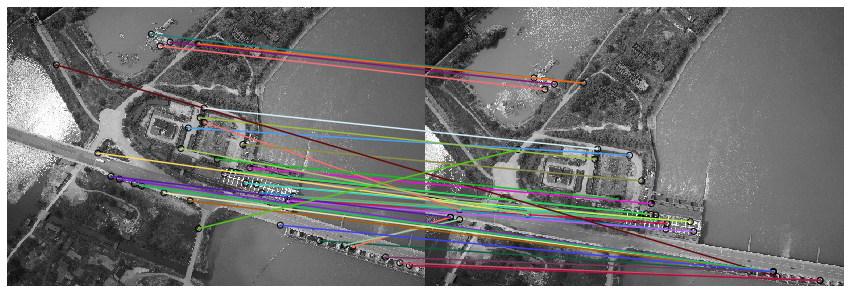

In [88]:
matches = description_matches(desc1,desc2,threshold=0.7)

fig,ax = plt.subplots(1,1,figsize=(15,12))

ax.axis('off')
plot_matches(ax,image1,image2,keypoint1,keypoint2,matches)
plt.show()

In [156]:
pts1 = []
pts2 = []
for one_match in matches:
    index1 = one_match[0]
    index2 = one_match[1]
    pts1.append([keypoint1[index1,0],keypoint1[index1,1]])
    pts2.append([keypoint2[index2,0],keypoint2[index2,1]])
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

In [157]:
F, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC)

In [101]:
# 寻则内部点
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]


In [109]:
H1,W1 = image1.shape
H2,W2 = image2.shape
if H1>H2:
    new_image2 = np.zeros((H1,W2))
    new_image2[:H2,:] = image2
    image2 = new_image2
if H1<H2:
    new_image1 = np.zeros((H2,W1))
    new_image2[:H1,:]=image1
    image1 = new_image1
image = np.concatenate((image1,image2),axis=1)

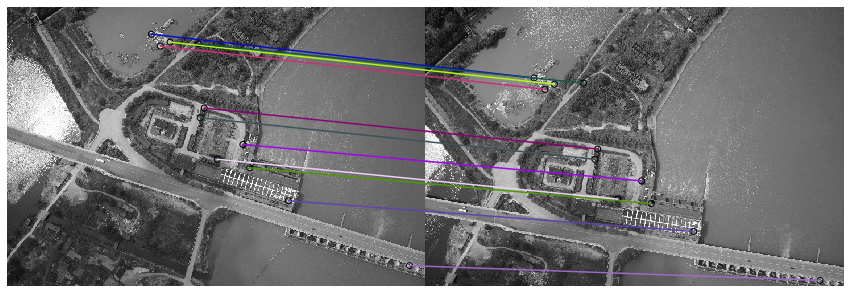

In [120]:
fig,ax = plt.subplots(1,1,figsize=(15,12))

ax.axis('off')
ax.imshow(image,interpolation='nearest',cmap='gray')

for i in range(len(pts1)):
    color = np.random.rand(3)
    ax.scatter(pts1[i][1],pts1[i,0],facecolors='none',edgecolors='k')
    ax.scatter(pts2[i,1]+image1.shape[1],pts2[i,0],facecolors='none',edgecolors='k')
    ax.plot((pts1[i,1],pts2[i,1] + image1.shape[1]),
        (pts1[i,0],pts2[i,0]),'-',color=color)
plt.show()

In [163]:
img_changed = cv2.warpPerspective(image2, F, (image2.shape[1]*2,image2.shape[0]*2))

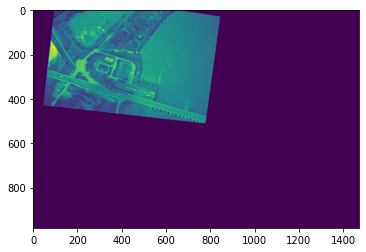

In [164]:
plt.imshow(img_changed)

In [165]:
res = stitch_images(image1, img_changed)
# res = remove_black_pad(res)

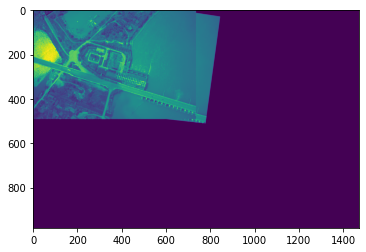

In [166]:
plt.imshow(res)

# 完整版，上面的是教程

In [27]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

In [28]:
def show_img(img):
    img = np.uint8(img)
    x,y = img.shape[0], img.shape[1]
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

In [30]:
# 采集特征点
def get_Homo_matrix(img1, img2):
    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)                 # 检测特征点
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)       # 暴力匹配
    matches = bf.match(des1, des2)
    # 选取前100个匹配度较高的点
    matches = sorted(matches, key=lambda x: x.distance)[:100]
    if verbose:
        show_img(cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2))

    pts1 = []
    pts2 = []
    for m in range(len(matches)):
        pts1.append(kp1[matches[m].queryIdx].pt) 
        pts2.append(kp2[matches[m].trainIdx].pt)
        
    # 单应性匹配
    H, mask = cv2.findHomography(np.float32(pts1), np.float32(pts2), cv2.RANSAC)
    
#     # 基础矩阵匹配
#     H, mask = cv2.findFundamentalMat(np.float32(pts1), np.float32(pts2), cv2.RANSAC) 

    if verbose:
        matches = np.array(matches)
        matches = matches[mask.ravel() == 1].tolist()
        show_img(cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2))
    
    return H, mask


In [31]:
# 仿射变换后的图像拼接
def stitch_images(src, dst):
    H, W = src.shape[0], src.shape[1]
    for i in range(H):
        for j in range(W):
            flag = (src[i, j, :] != np.array([0, 0, 0])) 
            if flag.any():
                dst[i, j] = src[i, j]
    return dst

In [32]:
# 去黑边
def remove_black_pad(img):
    H, W = img.shape[0], img.shape[1]
    
    left = 0
    for i in range(0, H):
        if (img[:, i, :] != np.array([0, 0, 0])).any():
            left = i
            break
            
    right = W
    for i in range(left, W):
        if (img[:, i, :] == np.array([0, 0, 0])).all():
            right = i
            break
    
    top = 0
    for i in range(0, H):
        if (img[i, :, :] != np.array([0, 0, 0])).any():
            top = i
            break
    
    bottom = H
    for i in range(top, H):
        if (img[i, :, :] == np.array([0, 0, 0])).all():
            bottom = i
            break
#     print(top,bottom,left,right)
    return img[top:bottom,left:right,:]

In [33]:
# 对应变换拼接两张图片
def two_img_stitch(res, next_img):
    HH, extra = get_Homo_matrix(next_img, res)
    # res 不动，以res为视角对cur_img进行当前视角下的仿射变换
    img_changed = cv2.warpPerspective(next_img, HH, (res.shape[1] + next_img.shape[1], res.shape[0] + next_img.shape[0]))
    if verbose:
        show_img(img_changed)
    res = stitch_images(res, img_changed)
    # 去黑边
    res = remove_black_pad(res)
    # 加padding，防止界外截断
    res = cv2.copyMakeBorder(res, padd, padd, padd, padd, cv2.BORDER_CONSTANT, 0)
    if verbose:
        show_img(res)
    return res

In [49]:
# 拼接图像队列，有固定视角
def imglist_stitch(imglist):
    img_count = len(imglist)
#     view_point = int(img_count/2)
    view_point = 1
    res = imglist[view_point].copy()
    
    for cur_img_idx in range(img_count):
        print("%d/%d" % (cur_img_idx + 1, img_count))
        if cur_img_idx!=view_point:
            cur_img = imglist[cur_img_idx]
            res = two_img_stitch(res, cur_img)
            
    res = remove_black_pad(res)    
    return res

In [50]:
# 拼接图像队列，以类似于haffman树的方式拼接
# 视角尽量往中间靠
def imglist_stitch_haff(imglist):
    
    img_count = len(imglist)
    mid_idx = int(img_count/2)
    
    while True:
        if(img_count<=1):
            break
            
        new_stitch_imglist = []
        
        for cur_img_idx in range(0, img_count - 1, 2):
            print("%d/%d" % (cur_img_idx + 1, img_count))
            res = imglist[cur_img_idx].copy()
            next_img = imglist[cur_img_idx + 1].copy()
            # 以靠近中间视角的图像作为不动图，另一张图进行仿射变换
            if cur_img_idx<mid_idx:
                res, next_img = next_img, res
            res = two_img_stitch(res, next_img)
            new_stitch_imglist.append(res)

        # 单数图剩最后一张
        if(img_count % 2 == 1):
            print("%d/%d" % (img_count - 1 - 1, img_count))
            res = imglist[img_count - 1 - 1].copy()
            next_img = imglist[img_count - 1].copy()
            res = two_img_stitch(res, next_img)
            new_stitch_imglist.append(res)
            
        imglist = new_stitch_imglist.copy()
        img_count = len(imglist)
        mid_idx = int(img_count/2)
            
    res = remove_black_pad(imglist[0]) 
    
    return res

In [92]:
def cv2_imread(filePath):
    cv2_img=cv2.imdecode(np.fromfile(filePath,dtype=np.uint8),-1)
    return cv2_img

In [93]:
def cv2_imwrite(filePath, img):
    cv2.imencode('.jpeg', img)[1].tofile(filePath)

In [101]:
if __name__ == '__main__':

    file_path = "./图像拼接数据/旋转_缩放/2/"
    
#     filename_list = glob.glob("./data/*.jpg")
    filename_list = glob.glob(file_path + "*.jpg")
    # 如果需要查看详细过程的话，建议缩小一定的图片比例
    verbose = False
    padd = 0
    # 图片缩放比例
    # 如果进行图像缩放，有可能会使得图像拼接失败
    img_scale = 1
    img_list = []
    for filename in filename_list:
#         img = cv2.imread(filename)
        img = cv2_imread(filename)
        x, y, _ = img.shape
        img = cv2.resize(img, (y // img_scale, x // img_scale))
        padd = max(padd,max(x // img_scale,y // img_scale))
        img = cv2.copyMakeBorder(img, padd, padd, padd, padd, cv2.BORDER_CONSTANT, 0)
        img_list.append(img)
    
    if(len(img_list) == 0):
        print("当前文件夹内没有图像！")
        sys.exit()
    
    combine = imglist_stitch_haff(img_list.copy())
#     cv2.imwrite(file_cudapath + "final_huff.jpeg", combine)
    cv2_imwrite(file_path + "final_huff.jpeg", combine)
    show_img(combine)    

1/2
